<a href="https://colab.research.google.com/github/Divgithub045/multi_disease_pred_from_chest_x-ray/blob/main/covi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install -q kaggle

In [32]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"divyanshnrj","key":"b8995f0f9735f79facfd0e3468134c89"}'}

In [33]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [34]:
!chmod 600 ~/.kaggle/kaggle.json

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-covid19-pneumonia


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
import os
print(os.listdir(path+'/Data/test'))

['PNEUMONIA', 'NORMAL', 'COVID19']


In [38]:
train = train_datagen.flow_from_directory(path+'/Data/train',
                                          target_size=(224,224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          shuffle=True)
test = test_datagen.flow_from_directory(path+'/Data/test',
                                        target_size=(224,224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [39]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes= np.unique(train.classes),
                                               y= train.classes)
clss_weights = dict(enumerate(class_weights))
print(clss_weights)

{0: np.float64(3.727536231884058), 1: np.float64(1.3543970510795156), 2: np.float64(0.501657889604057)}


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [41]:
model = Sequential(
    [Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
     Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')]
)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
import tensorflow as tf

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(name='precission')])

In [44]:
import tensorflow

In [47]:
history = model.fit(
    train,
    epochs=30,
    validation_data=test,
    class_weight=clss_weights,
    callbacks=[
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_precission',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 138s 827ms/step - accuracy: 0.8260 - loss: 0.4214 - precission: 0.8398 - val_accuracy: 0.8967 - val_loss: 0.2896 - val_precission: 0.9006
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 136s 802ms/step - accuracy: 0.8606 - loss: 0.3254 - precission: 0.8693 - val_accuracy: 0.8688 - val_loss: 0.3326 - val_precission: 0.8751
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 129s 800ms/step - accuracy: 0.8745 - loss: 0.2860 - precission: 0.8808 - val_accuracy: 0.9115 - val_loss: 0.2352 - val_precission: 0.9156
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 796ms/step - accuracy: 0.8797 - loss: 0.2923 - precission: 0.8871 - val_accuracy: 0.9138 - val_loss: 0.2571 - val_precission: 0.9158
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 135s 835ms/step - accuracy: 0.8893 - loss: 0.2685 - precission: 0.8935 - val_accuracy: 0.9317 - val_loss: 0.1988 - val_precission: 0.9331
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 129s 803ms/step - accuracy: 0.8970 - loss: 0.2304 - precission: 0.9008

In [48]:
import numpy as np

In [49]:
print (history.history['val_accuracy'][-1])

0.9270186424255371


In [50]:
from sklearn.metrics import classification_report
y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test.classes, y_pred,target_names=['Pneumonia','Normal','Covid19']))

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step
              precision    recall  f1-score   support

   Pneumonia       0.97      0.97      0.97       116
      Normal       0.83      0.96      0.89       317
     Covid19       0.98      0.93      0.95       855

    accuracy                           0.94      1288
   macro avg       0.93      0.95      0.94      1288
weighted avg       0.94      0.94      0.94      1288



In [51]:
import os

for category in ['PNEUMONIA', 'NORMAL', 'COVID19']:
    print(category, 'Train:', len(os.listdir(f'{path}/Data/train/{category}')),
          'Val:', len(os.listdir(f'{path}/Data/test/{category}')))

PNEUMONIA Train: 3418 Val: 855
NORMAL Train: 1266 Val: 317
COVID19 Train: 460 Val: 116


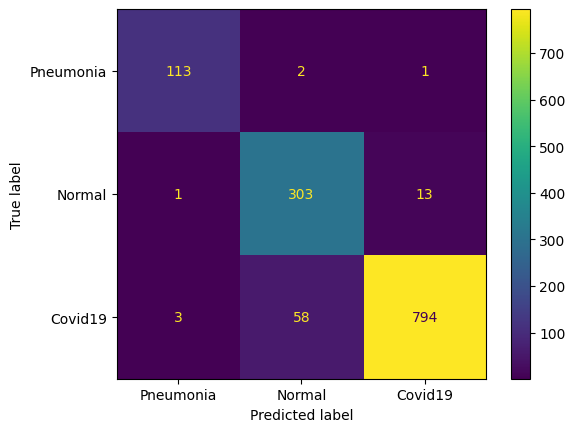

In [52]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(test.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Pneumonia','Normal','Covid19'])
disp.plot()


In [53]:
model.save('model.h5')

In [54]:
!ls -lh model.h5

-rw-r--r-- 1 root root 67M Jul 13 03:33 model.h5


In [55]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>